In [1]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
#from tensorflow_probability import experimental
#tfd = tfp.distributions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import healpy as hp
#import pandas as pd
import camb 
from camb import model, initialpower
import glob
import pylab as plty
from PIL import Image
from healpy.sphtfunc import Alm

%matplotlib inline


In [2]:
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    '''
    Generate a basic map which is just an array with element values which are increasing from a 'start' to a 'stop'.
    '''
    _NPIX = 12*_NSIDE**2 #The number of pixels in a map, NPIX = 12*(NSIDE)^2
    return   np.linspace(_strt,_stop,_NPIX)        #generates an array in the 'ring' scheme


In [3]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    if _lmax <= 2551: #can only find power spectrum for lmax <= 2551 since that is the maximum value of the data.
        pars = camb.CAMBparams()
        pars.set_cosmology(H0 = _parameters[0], ombh2 = _parameters[1], omch2 = _parameters[2], mnu = _parameters[3],
                   omk = _parameters[4], tau = _parameters[5])  #Inputs the given cosmological parameters.
        pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        
        pars.set_for_lmax(_lmax, lens_potential_accuracy=0) #input the given lmax value
        
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK') #returns the power spectrum in units muK.
        
        totCL=powers['total'] #returns the total (averaged) power spectrum - including lensed, unlensed power spectra 
        _DL = totCL[:,0] 
        
        #unlensedCL=powers['unlensed_scalar'] #returns the unlensed scalar power spectrum
        #_DL = unlensedCL[:,0] # 
    
        _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
        _CL = []
        for i in range(_lmax): #also limits the length of power spectrum to the requested length
            if i == 0:
                _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
            else:
                _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
        _CL = np.array(_CL)    
    
        return _CL 
    
    else: #prints error if lmax is too large.
        print('lmax value is larger than the available data.')

In [4]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")

#PLots a map in the mollview projection 
def mollviewmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [5]:
#Adds random noise to each pixel on a map given a variance 
def noisemapfunc(_map,_var):
    _noisevec = np.random.normal(0,_var,len(_map))
    _newmap = [x + y for x, y in zip(_map, _noisevec)]
    _newmap, _noisevec = np.array(_newmap), np.array(_noisevec)
    return [_newmap, _noisevec] #returns an array consisiting of [map with added noise, array of the added noise]


In [6]:
#cls --> something
def cltoalm(_cls, _NSIDE): #does this manually - doesn't work
    _alms = []
    _lmax = (3*_NSIDE)
    _count = 0
    for l in range(_lmax): 
        if _cls[l] > 0:
            _alms.append(np.complex(np.random.normal(0,_cls[l]),0))        #set m=0, which is real
        else:
            _alms.append(np.complex(0,0))
        
        for m in range(l): #set positive m's
            if _cls[l] > 0 and _cls[m] > 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])))
            if _cls[l] > 0 and _cls[m] <= 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),0))
            if _cls[l] <= 0 and _cls[m] > 0:
                _alms.append(np.complex(0,np.random.normal(0,0.5*_cls[m])))
            else:
                _alms.append(np.complex(0,0))
    
    return _alms   

def hpcltoalm(_cls, _NSIDE): #Healpy generate alms given cls
    return hp.synalm(_cls, lmax = (3*_NSIDE) - 1, new = True)

def cltomap(_cls, _NSIDE):
    _alm = cltoalm(_cls, _NSIDE)
    return almtomap(_alm, _NSIDE)

def hpcltomap(_cls, _NSIDE):   #Healpy generate a map given a power spectrum
    return hp.synfast(_cls, _NSIDE, new=True)   #pixwin=False, fwhm=np.radians(7.0),


In [7]:
#map --> something
def maptocl(_map):
    return

def hpmaptocl(_map): #Generate a power spectrum given cls
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)))    #lmax = 3NSIDE -1 by default

def maptoalm(_map):
    _omegp = (4*np.pi)/len(_map)
    _lmax = int(np.sqrt(len(_map)*(3/4)))
    _NSIDE = int(_lmax/3)
    _alm = []
    for l in range(_lmax):
        for m in range(l+1):
            _TpYlm = []
            for i in range(len(_map)):
                _TpYlm.append(_map[i]*np.conjugate(sphharm(m, l, i, _NSIDE)))
                    
            _alm.append(_omegp*sum(_TpYlm))
    
    return np.array(_alm)


def hpmaptoalm(_map, _lmax): #Healpy generate alms from map. 
    return hp.map2alm(_map, _lmax)


In [30]:
#alm --> something
def almtocl(_alm,lmax): #alm --> cl using alms in my ordering (different to healpys).
    _l = np.arange(lmax)
    _scaling = 1 / ((2*_l + 1))
    count = 0
    _new = []
    _cl = []
    for l in range(lmax):
        _new.append([])
        for m in range(l):
            if m == 0:
                _new[l].append(np.absolute(_alm[count])**2)
                count = count + 1
                
            if m > 0:
                _new[l].append(2*np.absolute(_alm[count])**2)
                count = count + 1
              
    for i in range(len(_new)):
        _cl.append(_scaling[i] * sum(_new[i]))
    
    return _cl

def hpalmtocl(_alms, _lmax): #Healpy estimates the power spectrum from the cls.
    return hp.alm2cl(_alms, lmax = _lmax)

def almtomap(_alm, _NSIDE ):# alm --> map using alms in my ordering (different to healpys).
    _map = []
    _Npix = 12*(_NSIDE)**2
    _lmax = (3*_NSIDE)

    for i in range(_Npix):
        _sum = []
        _count = 0
        for l in np.arange(0,_lmax):
            for m in np.arange(0,l+1):
                if m == 0:
                    _sum.append(_alm[_count]*sphharm(m,l,i, _NSIDE))
                    _count = _count + 1
                else:
                    _sum.append(2*(np.real(_alm[_count])*np.real(sphharm(m,l,i, _NSIDE)) -
                                   np.imag(_alm[_count])*np.imag(sphharm(m,l,i, _NSIDE))))
                    _count = _count + 1
        _map.append(sum(_sum))

    return np.real(_map)
        

def almtomap_tf(_alm, _NSIDE): #alm --> map for tensorflow using alms in my ordering (different to healpys).
    _map = tf.constant([])
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = tf.constant([])
        _count = 0
        for l in range(_lmax):
            for m in range(l+1):
                if m==0:
                    _sum = tf.concat((_sum,[_alm[_count]*sphharm(m,l,i, _NSIDE)]), axis = 0)
                    _count = _count + 1
                else:
                    _sum = tf.concat((_sum,[2*((np.real(_alm[_count]))*(np.real(sphharm(m,l,i, _NSIDE)))-
                                               np.imag(_alm[_count])*np.imag(sphharm(m,l,i, _NSIDE)))]), axis = 0)
                    _count = _count + 1
        _map = tf.concat((_map,[sum(_sum)]), axis = 0)
    return tf.convert_to_tensor(_map)


def almtomap_tf2(_alm,_NSIDE):
    _map = tf.Variable([])
    _lmax = (3*_NSIDE)
    _ralm = tf.math.real(_alm) 
    _ialm = tf.math.imag(_alm) 
    _rsph = tf.math.real(_sph) 
    _isph = tf.math.imag(_sph) 
    _map = tf.Variable(np.array([]))
    for i in range(12*(_NSIDE)**2):
        _count = 0
        _term1 = tf.Variable(0.0,dtype = np.float32)
        for l in range(_lmax):
            for m in range(l+1):
                if m==0:
                    tf.compat.v1.assign_add(_term1, _ralm[_count]*_rsph[i][_count])
                    _count = _count + 1
                else:
                    tf.compat.v1.assign_add(_term1,2*(_ralm[_count]*_rsph[i][_count] - 
                                                                  _ialm[_count]*_isph[i][_count]),0.0)
                    _count = _count + 1

        _map = tf.concat((_map, [_term1]), axis = 0)
    _map = tf.dtypes.cast(_map, tf.float32)
    return _map

def almtomap_tf3(_alm,_NSIDE):
    _lmax = (3*_NSIDE)
    _ralm = tf.math.real(_alm) 
    _ialm = tf.math.imag(_alm) 
    _rsph = tf.math.real(_sph) 
    _isph = tf.math.imag(_sph) 

    _map1 = tf.linalg.matvec(_rsph,_ralm)
    _map2 = tf.linalg.matvec(_isph,_ialm)
    _map = 2*(_map1 - _map2)
    return _map


def hpalmtomap(_alms, _NSIDE):
    return hp.alm2map(_alms, _NSIDE)

print(len(_sph[0]))

21


In [9]:
#healpy smoothing for the map and the alms
def hpmapsmooth(_map, _lmax): #smooths a given map with a gaussian beam smoother.
    return hp.smoothing(_map, lmax = _lmax)


def hpalmsmooth(_alms): #smooths a given set of alms with a gaussian beam smoother.
    return hp.smoothalm(_alms, fwhm = 0.0)
    

In [10]:
#splits/rejoins the alms into real/imaginary parts so that they can be optimised with scipy.optimize.minimize()
def singulartosplitalm(_alm):
    _realalm, _imagalm = _alm.real, _alm.imag
    return [_realalm, _imagalm]
    

def splittosingularalm(_realalm, _imagalm):
    _alm = []
    for i in range(len(_realalm)):
        _alm.append(complex(_realalm[i], _imagalm[i]))
    return _alm


def splittosingularalm_tf(_realalm, _imagalm): #takes the real and imaginary parts of the alms and creates a tensor
    return tf.complex(_realalm,_imagalm)



In [11]:
#Retrieves the spherical harmonics for a given, l, m and pixel number
def sphharm(m, l, _pixno, _NSIDE):
    _theta, _phi = hp.pix2ang(nside=_NSIDE, ipix=_pixno)
    return sp.special.sph_harm(m, l, _phi, _theta)
    
    

In [12]:
def almmotho(_moalm, _lmax):
    '''changing the alm ordering from my ordering to healpys'''
    _hoalm = []
    _count4 = []
    _count5 = 0
    for i in np.arange(2,_lmax+2):
        _count4.append(_count5)
        _count5=_count5+i
    for i in range(_lmax):
        _count1 = 0 #_count4[i]
        _count2 = np.arange(0,_lmax,1)
        _count3 = np.arange(_lmax,0,-1)
        for j in np.arange(i+1,_lmax+1):
            _hoalm.append(_moalm[_count1+_count4[i]])
            _count1 = _count1 + j
    return np.array(_hoalm)


def almhotmo(_hoalm, _lmax):
    '''changing the alm ordering from healpys ordering to mine'''
    _moalm = np.zeros(sum(np.arange(_lmax+1)), dtype = complex)
    _count4 = []
    _count5 = 0
    for i in np.arange(2,_lmax+2):
        _count4.append(_count5)
        _count5 = _count5+i
    _count1 = 0
    for i in range(_lmax):
        _count2 = 0    
        for j in np.arange(i+1,_lmax+1):
            _moalm[_count2 + _count4[i]] = _hoalm[_count1]
            _count1 = _count1 + 1
            _count2 = _count2 + j        
    return np.array(_moalm)



In [13]:
def multtensor(_lmax,_lenalm):
    _shape = np.zeros([_lmax,_lenalm]) #matrix for the calculation of the psi in psi_tf
    _count = 0
    for i in range(_lmax):
        for j in np.arange(0,i+1):
            if j == 0:
                _shape[i][_count] = 1.0
                _count = _count + 1
            else:
                _shape[i][_count] = 2.0
                _count = _count + 1
    return tf.convert_to_tensor(_shape, dtype = tf.float32)



In [34]:
#negative log of the posterior, psi.
def psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _lncl, _realalm, _imagalm = [], [], []
    
    for i in range(len_cl):
        _lncl.append(_params[i])
    for i in range(len_ralm):
        _realalm.append(_params[i + len_cl])
    for i in range(len_ialm):
        _imagalm.append(_params[i + len_cl + len_ralm])
    
    _imagalm[0] = 0.0 
    
    _d = _map
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem, _term1, _term2, _psi1 ,_psi2, _psi3 = [], [], [], [], [], []
    _sum = 0
    
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi1.append(0.5*(_elem[i]**2)*_Ninv[i]) #first term in the taylor paper 
    
    _l = np.arange(_lmax)
    for i in range(len(_lncl)):
        _psi2.append((_l[i] + 0.5)*(_lncl[i]))
    
    
    for i in range(len(_lncl)):
        _term1.append([])
        for j in range(i+1):
            if j == _sum:
                _term1[i].append(np.absolute(_a[_sum])**2)
            else:
                _term1[i].append(2*np.absolute(_a[_sum])**2)
            _sum = _sum + 1
            if j == i:
                _term2.append(sum(_term1[i])) 
    for i in range(len(_lncl)):
        _psi3.append(_term2[i]/(2*np.exp(_lncl[i])))
    
    _psi = sum(_psi1) + sum(_psi2) + sum(_psi3) #third term in the taylor paper
    print('psi =',_psi)
    return _psi


def psi_tf(_params):
    _map, _lmax, _Ninv = noisemap_tf, lmax, Ninv
    #_map, _lmax, _Ninv = noisemap, lmax4, Ninv4
    _lncl = _params[:len_cl]
    _realalm = _params[len_cl:(len_ralm + len_cl)]
    _imagalm = _params[(len_ralm + len_cl):]
    
    _term1, _term2 = tf.slice(_imagalm, [0], [1]), tf.zeros(len(_imagalm)-1, dtype = np.float32)#
    _term3 = tf.concat([_term1,_term2], axis = 0)
    _imagalm = _imagalm - _term3
    
    _d = _map
    _a = splittosingularalm_tf(_realalm, _imagalm)
    _Ya = almtomap_tf3(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    
    #_d = tf.dtypes.cast(_d, tf.float32) 
    #_BYa = tf.dtypes.cast(_BYa, tf.float32)
    print(_d,_BYa)
    _elem = _d - _BYa
    _psi1 = 0.5*(_elem**2)*_Ninv
    
    _l = tf.range(_lmax, dtype = tf.float32)
    _psi2 = (_l+0.5)*_lncl
    
    _a = tf.math.abs(_a)**2
    _as = tf.linalg.matvec(shape,_a)
    _psi3 = 0.5*_as/tf.math.exp(_lncl)
    
    _psi = tf.reduce_sum(_psi1) #+ tf.reduce_sum(_psi2) + tf.reduce_sum(_psi3) 
    print('psi =',_psi)   
    return -_psi



In [39]:
a = tf.constant([1,2,3])
a = tf.convert_to_tensor(a)
b = tf.Variable(5)
a[1] = b

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a regis

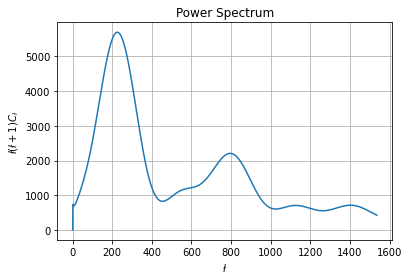

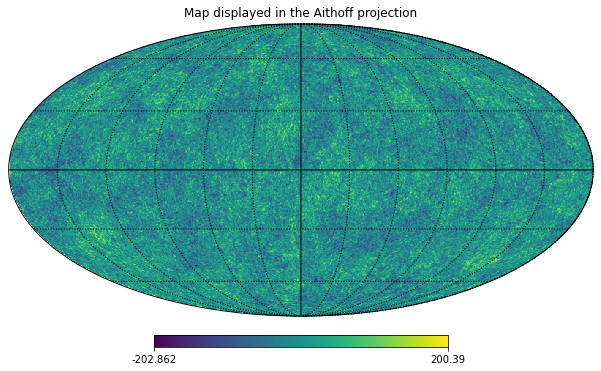

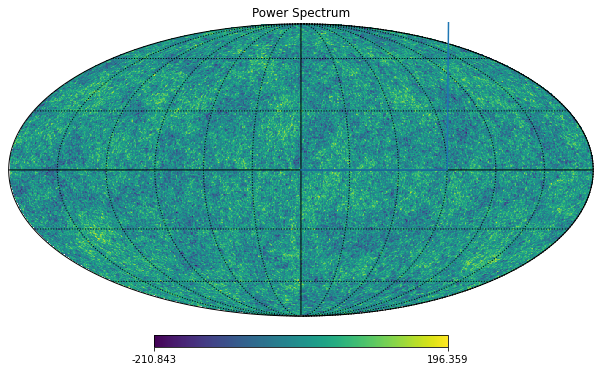

In [15]:
#Trial with parameters 1
parameters1 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax1 = 1536  #lmax value wanted from data
NSIDE1 = int(lmax1/3)  #len(cls1)/3   #3*nside = len(cls)
n1 = np.linspace(5,5,(12*(NSIDE1)**2))
Ninv1 = []
for i in range(len(n1)):
    Ninv1.append(1/(n1[i]**2)) #finds the inverse noise matrix

cls1 = call_CAMB_map(parameters1, lmax1) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls1) #plot of the power spectrum.
map1 = hpcltomap(cls1, NSIDE1)  #generates a map from the power spectrum
map1 = hpmapsmooth(map1, lmax1) #applies a gaussian beam smoother to the map
mollviewmap(map1) #plots the map
noisemap1 = noisemapfunc(list(map1),n1[0])[0] #adds noise to the map
mollviewmap(noisemap1) #plots the map with noise
hnoisealms1 = hpmaptoalm(noisemap1,lmax1) #computes the alms from the map with noise added.
noisecl1 = hpalmtocl(hnoisealms1, lmax1) #estimates the power spectrum from the given alms.
plotpwrspctrm(noisecl1) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a regis

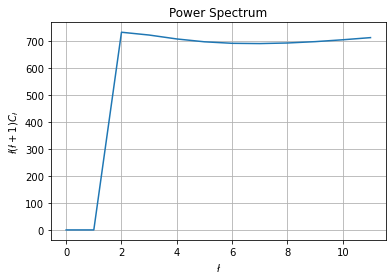

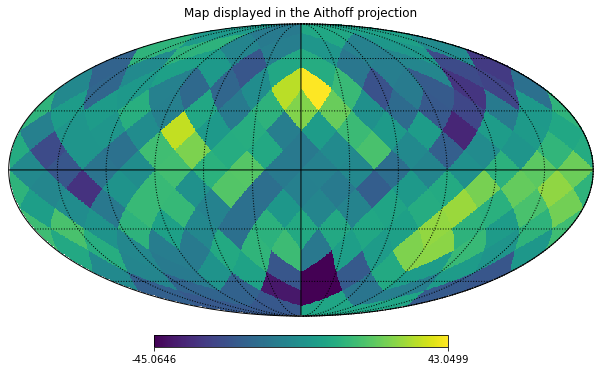

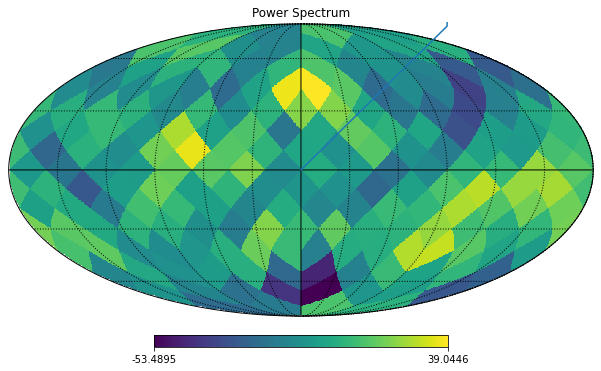

In [16]:
#Trial with parameters 2
parameters2 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax2 = 12   #lmax value wanted from data
NSIDE2 = int(lmax2/3)   #len(cls1)/3   #3*nside = len(cls)
n2 = np.linspace(5,5,(12*(NSIDE2)**2))
Ninv2 = []
for i in range(len(n2)):
    Ninv2.append(1/(n2[i]**2)) #finds the inverse noise matrix
    

cls2 = call_CAMB_map(parameters2, lmax2) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls2) #plot of the power spectrum.
map2 = hpcltomap(cls2, NSIDE2)  #generates a map from the power spectrum
map2 = hpmapsmooth(map2, lmax2) #applies a gaussian beam smoother to the map
mollviewmap(map2) #plots the map
noisemap2 = noisemapfunc(map2,n2[0])[0] #adds noise to the map
mollviewmap(noisemap2) #plots the map with noise
hnoisealms2 = hpmaptoalm(noisemap2,lmax2-1) #computes the alms from the map with noise added.
noisecl2 = hpalmtocl(hnoisealms2, lmax2-1) #estimates the power spectrum from the given alms.
plotpwrspctrm(noisecl2) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a regis

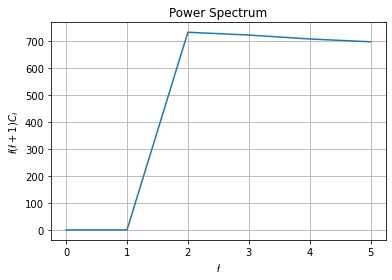

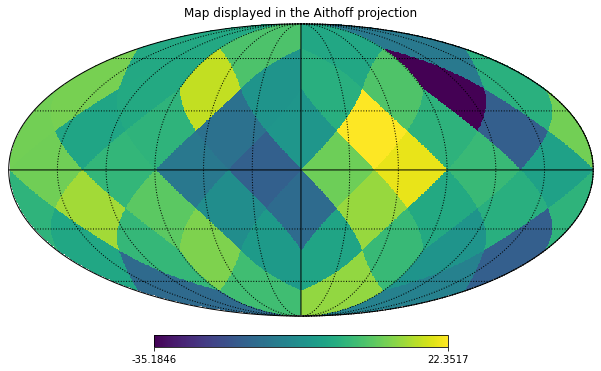

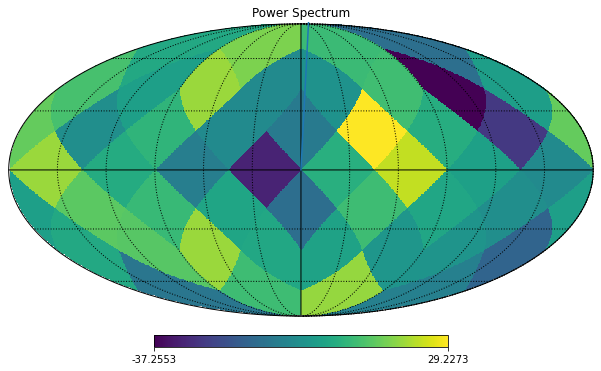

In [17]:
#Trial with parameters 3
parameters3 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax3 = 6  #lmax value wanted from data
NSIDE3 = int(lmax3/3)  #len(cls1)/3   #3*nside = len(cls)
n3 = np.linspace(5,5,(12*(NSIDE3)**2))
Ninv3 = []
for i in range(len(n3)):
    Ninv3.append(1/(n3[i]**2)) #finds the inverse noise matrix

cls3 = call_CAMB_map(parameters3, lmax3) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls3) #plot of the power spectrum.
map3 = hpcltomap(cls3, NSIDE3)  #generates a map from the power spectrum
map3 = hpmapsmooth(map3, lmax3) #applies a gaussian beam smoother to the map
mollviewmap(map3) #plots the map
noisemap3 = noisemapfunc(map3,n3[0])[0] #adds noise to the map
mollviewmap(noisemap3) #plots the map with noise
hnoisealms3 = hpmaptoalm(noisemap3,lmax3-1) #computes the alms from the map with noise added.
noisecl3 = hpalmtocl(hnoisealms3, lmax3-1) #estimates the power spectrum from the given alms.
plotpwrspctrm(noisecl3) #plots the estimated power spectrum.

/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a regis

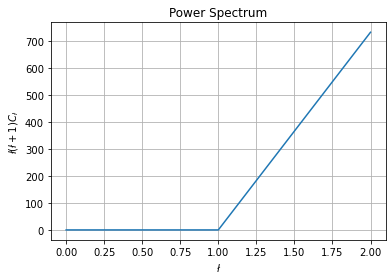

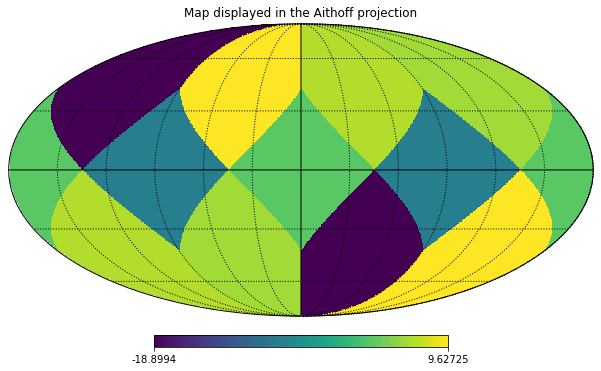

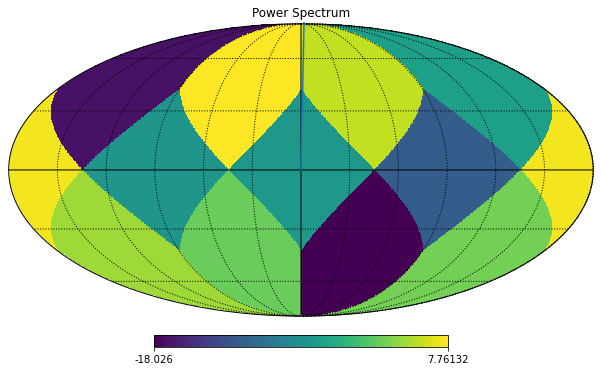

In [18]:
#Trial with parameters 4
parameters4 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax4 = 3  #lmax value wanted from data
NSIDE4 = int(lmax4/3)  #len(cls1)/3   #3*nside = len(cls)
n4 = np.linspace(5,5,(12*(NSIDE4)**2))
Ninv4 = []
for i in range(len(n4)):
    Ninv4.append(1/(n4[i]**2)) #finds the inverse noise matrix
    
cls4 = call_CAMB_map(parameters4, lmax4) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls4) #plot of the power spectrum.
map4 = hpcltomap(cls4, NSIDE4)  #generates a map from the power spectrum
map4 = hpmapsmooth(map4, lmax4) #applies a gaussian beam smoother to the map
mollviewmap(map4)
noisemap4 = noisemapfunc(map4,n4[0])[0] #adds noise to the map
mollviewmap(noisemap4)
hnoisealms4 = maptoalm(noisemap4) #alms in my ordering
noisecl4 = almtocl(hnoisealms4, lmax4) #
plotpwrspctrm(noisecl4) #plots the estimated power spectrum.


In [33]:
#inital values for the optimisation of psi (with the values from parameters4)
_number = 3

if _number == 1:
    lmax = lmax1
    noisemap = noisemap1
    clinit = noisecl1
    noisealm = almhotmo(hnoisealms1,lmax)
    Ninv = Ninv1
    orig_map = map1
    orig_cls = cls1
if _number == 2:
    lmax = lmax2
    noisemap = noisemap2
    clinit = noisecl2
    noisealm = almhotmo(hnoisealms2,lmax)
    Ninv = Ninv2
    orig_map = map2
    orig_cls = cls2
if _number == 3:
    lmax = lmax3
    noisemap = noisemap3
    clinit = noisecl3
    noisealm = almhotmo(hnoisealms3,lmax)
    Ninv = Ninv3
    orig_map = map3
    orig_cls = cls3
if _number == 4:
    lmax = lmax4
    noisemap = noisemap4
    clinit = noisecl4
    noisealm = almhotmo(hnoisealms4,lmax)
    Ninv = Ninv4
    orig_map = map4
    orig_cls = cls4

NSIDE = int(lmax/3)
_sph = []
for i in range(int((lmax**2)*4/3)):
    _sph.append([])
    for l in range(lmax):
        for m in range(l+1):
            _theta, _phi = hp.pix2ang(nside=NSIDE, ipix=i)
            _sph[i].append(sp.special.sph_harm(m, l, _phi, _theta))
_sph = tf.convert_to_tensor(_sph, dtype = np.complex64)
noisemap_tf = tf.convert_to_tensor(noisemap, dtype = np.float32)
realalminit = noisealm.real
imagalminit = noisealm.imag
x0 = []
len_cl = len(clinit)
len_ralm = len(realalminit)
len_ialm = len(imagalminit)
shape = multtensor(lmax,len_ralm) #A tensor for the spherical harmonics in the maptoalm_tf function
for i in range(len(clinit)):
    if clinit[i] > 0:
        x0.append(np.log(clinit[i]))
    else:
        x0.append(0)
for i in range(len(realalminit)):
    x0.append(realalminit[i])
for i in range(len(imagalminit)):
    x0.append(imagalminit[i])
psi(x0,noisemap,lmax,Ninv)
x0_tf = tf.convert_to_tensor(x0, dtype = np.float32)
psi_tf(x0_tf)


psi = 90.42042798983502
tf.Tensor(
[ 16.177551     2.8742054  -12.884229     7.9794044   -5.4032393
  19.328773     0.37628722   9.8656025   -0.10446183 -37.255257
   8.928955    -3.490186    -9.970832    -5.548491     6.288586
  -4.374982    13.406344   -26.32593      4.073684    29.227325
 -30.620548    -8.8244295    3.7039354   19.329262    -5.5447974
   0.55603915  23.08182      4.7976847  -13.319928     1.8853556
   7.475108    12.529135     0.38382444  -4.382756     2.1249313
   8.5358       2.5574927   19.247355    11.903914     2.8241768
 -15.888511    -2.9376025   -2.306532     0.94515526   8.661904
 -11.139504    -8.323944    18.717463  ], shape=(48,), dtype=float32) tf.Tensor(
[ 19.01196      6.2733445   -5.518501     8.504459    -3.354642
  19.167486    -0.08547211   7.6343203   -4.2378473  -38.041348
   7.768372    -0.96979773 -15.361053    -8.904795     6.474968
  -1.6449766   17.908915   -25.784904     4.54502     29.21657
 -23.106276    -4.7117434    2.2263393   16.2719

<tf.Tensor: shape=(), dtype=float32, numpy=-8.320766>

In [20]:
#Optimising the parameters of the posterior (the 'psi' funciton), to get the parameters corresponding to its min.
'''
sp.optimize.fmin(psi, x0, args = (noisemap, lmax4, Ninv4), xtol=5)
'''


'\nsp.optimize.fmin(psi, x0, args = (noisemap, lmax4, Ninv4), xtol=5)\n'

In [35]:
def run_chain1(initial_state, num_results=10, num_burnin_steps=5): 
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=hmc_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)


hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi_tf, step_size=0.1, num_leapfrog_steps=2)#, state_gradients_are_stopped=True)



samples1, kernel_results1 = run_chain1(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results1.is_accepted.numpy().mean()) 


tf.Tensor(
[ 16.177551     2.8742054  -12.884229     7.9794044   -5.4032393
  19.328773     0.37628722   9.8656025   -0.10446183 -37.255257
   8.928955    -3.490186    -9.970832    -5.548491     6.288586
  -4.374982    13.406344   -26.32593      4.073684    29.227325
 -30.620548    -8.8244295    3.7039354   19.329262    -5.5447974
   0.55603915  23.08182      4.7976847  -13.319928     1.8853556
   7.475108    12.529135     0.38382444  -4.382756     2.1249313
   8.5358       2.5574927   19.247355    11.903914     2.8241768
 -15.888511    -2.9376025   -2.306532     0.94515526   8.661904
 -11.139504    -8.323944    18.717463  ], shape=(48,), dtype=float32) tf.Tensor(
[ 19.01196      6.2733445   -5.518501     8.504459    -3.354642
  19.167486    -0.08547211   7.6343203   -4.2378473  -38.041348
   7.768372    -0.96979773 -15.361053    -8.904795     6.474968
  -1.6449766   17.908915   -25.784904     4.54502     29.21657
 -23.106276    -4.7117434    2.2263393   16.271929    -4.618692
   2.421

psi = tf.Tensor(8.95156, shape=(), dtype=float32)
tf.Tensor(
[ 16.177551     2.8742054  -12.884229     7.9794044   -5.4032393
  19.328773     0.37628722   9.8656025   -0.10446183 -37.255257
   8.928955    -3.490186    -9.970832    -5.548491     6.288586
  -4.374982    13.406344   -26.32593      4.073684    29.227325
 -30.620548    -8.8244295    3.7039354   19.329262    -5.5447974
   0.55603915  23.08182      4.7976847  -13.319928     1.8853556
   7.475108    12.529135     0.38382444  -4.382756     2.1249313
   8.5358       2.5574927   19.247355    11.903914     2.8241768
 -15.888511    -2.9376025   -2.306532     0.94515526   8.661904
 -11.139504    -8.323944    18.717463  ], shape=(48,), dtype=float32) tf.Tensor(
[ 18.660872     6.773385    -4.974167     9.192507    -2.1640348
  18.736008     0.41543388   7.772604    -3.6669838  -37.262108
   7.2780933    1.2391428  -14.881895    -7.894294     6.7300243
  -2.7577457   18.02283    -24.663494     3.7995691   30.945656
 -22.617971    -3.9

 -11.139504    -8.323944    18.717463  ], shape=(48,), dtype=float32) tf.Tensor(
[ 19.691687     6.566681    -3.607464    10.240442    -2.2492964
  16.914536    -1.6988125    8.248516    -2.9768734  -37.015068
   7.0068426    0.42492455 -14.859601    -8.954496     6.657846
  -2.8479404   18.310778   -25.218891     4.137671    31.477922
 -23.782887    -2.6693392    1.6517847   15.305197    -4.216212
   1.1374781   26.224766    11.680447   -12.437339    -0.40719604
  10.356988    17.016567     2.028662    -2.5746212    1.691474
   8.938441     6.0867023   22.726484    11.442421     4.2447953
 -12.8828945    0.33077955  -0.16762733   4.4733496   12.778677
  -9.879818    -3.6505427   17.849703  ], shape=(48,), dtype=float32)
psi = tf.Tensor(10.907131, shape=(), dtype=float32)
tf.Tensor(
[ 16.177551     2.8742054  -12.884229     7.9794044   -5.4032393
  19.328773     0.37628722   9.8656025   -0.10446183 -37.255257
   8.928955    -3.490186    -9.970832    -5.548491     6.288586
  -4.374982  

 -11.139504    -8.323944    18.717463  ], shape=(48,), dtype=float32) tf.Tensor(
[ 18.315556    3.493072   -5.063149    7.993438   -2.892777   17.466196
  -2.4003544   6.891177   -2.9383001 -36.13398     6.200971   -1.0530611
 -14.118557   -7.963398    6.378684   -1.6362038  18.79264   -23.938524
   4.1690283  32.168716  -24.819435   -2.5984259   1.4106582  15.399035
  -3.7197275   0.4629124  26.79953    12.931226  -13.45407    -2.7116277
   9.812536   17.753277    1.2083671  -3.2666845   1.8574066   8.608372
   4.478178   21.589306   12.861315    5.1651444 -13.642477   -0.8760257
  -0.6222601   4.368209   12.172306   -9.666958   -6.0354037  17.074415 ], shape=(48,), dtype=float32)
psi = tf.Tensor(9.664627, shape=(), dtype=float32)
tf.Tensor(
[ 16.177551     2.8742054  -12.884229     7.9794044   -5.4032393
  19.328773     0.37628722   9.8656025   -0.10446183 -37.255257
   8.928955    -3.490186    -9.970832    -5.548491     6.288586
  -4.374982    13.406344   -26.32593      4.073684    

Acceptance rate: 1.0


In [113]:
def run_chain2(_initial_state, num_results=1000, num_burnin_steps=500):
    '''Uses HMC to step through parameter space with an adaptive step size.'''
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(hmc_kernel,
                                                        num_adaptation_steps=int(.8 * num_burnin_steps),
                                                        target_accept_prob=np.float32(.65))
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                                 current_state=_initial_state, kernel=adaptive_kernel,
                                 trace_fn=lambda cs, kr: kr)


samples2, kernel_results2 = run_chain2(tf.convert_to_tensor(x0))
print("Acceptance rate:", kernel_results2.inner_results.is_accepted.numpy().mean())

NameError: name 'hmc_kernel' is not defined

In [213]:
def run_chain3(initial_state, num_results=100, num_burnin_steps=50): 
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=nut_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=10, 
                                     max_energy_diff=1000.0, unrolled_leapfrog_steps=1,
                                     parallel_iterations=10) #, state_gradients_are_stopped = True)

samples3, kernel_results3 = run_chain1(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results1.is_accepted.numpy().mean()) 

NameError: name 'x0_tf' is not defined

In [218]:
samples = samples1

In [96]:
print('Samples:', samples) #print the samples from the adaptive step size HMC

Samples: tf.Tensor(
[[ 0.66749823 -1.002104    3.6935525  ...  3.0374138   0.54809636
   1.2071866 ]
 [ 0.66749823 -1.002104    3.6935525  ...  3.0374138   0.54809636
   1.2071866 ]
 [ 0.66749823 -1.002104    3.6935525  ...  3.0374138   0.54809636
   1.2071866 ]
 ...
 [ 0.99275374 -1.706923    4.5011024  ...  2.7503138   0.10679021
   1.593182  ]
 [ 0.99275374 -1.706923    4.5011024  ...  2.7503138   0.10679021
   1.593182  ]
 [ 0.90212154 -1.7970951   4.594617   ...  2.8696163  -0.3295194
   1.8330102 ]], shape=(100, 168), dtype=float32)


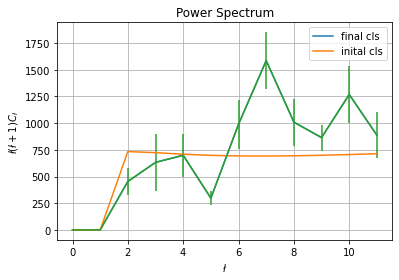

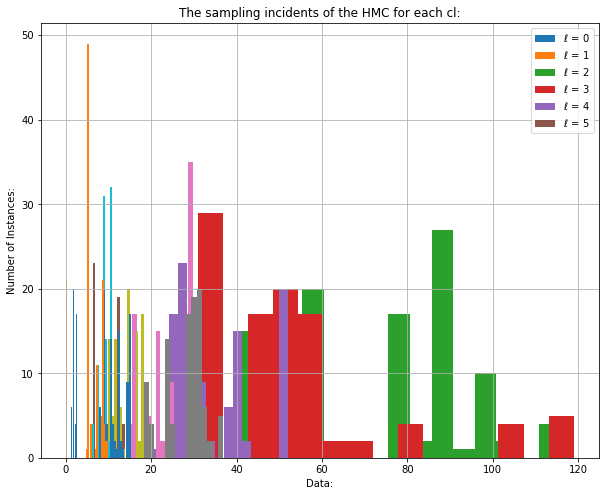

In [97]:
lncl_samples = tf.slice(samples,[0,0],[len(samples),lmax]) #The sampled cls from the adaptive step size HMC
cl_samples = tf.math.exp(lncl_samples)
mean_cl = [tf.math.reduce_mean(cl_samples[:,i])  for i in range(lmax)] #The mean of the sampled cls from the adaptive step size HMC
std_cl = [tf.math.reduce_std(cl_samples[:,i])  for i in range(lmax)] #The standard deviation of the = sampled cls from the adaptive step size HMC
plt.figure()
plotpwrspctrm(mean_cl) # Plot of the mean sampled cls
plotpwrspctrm(cls2) #Plot of the original cls
ell = np.arange(lmax)
plt.errorbar(ell,(ell*(ell+1)*mean_cl),xerr = 0, yerr = (ell*(ell+1)*std_cl))
plt.grid()
plt.legend(('final cls','inital cls'))
plt.show()

plt.figure(figsize = [10,8])
[plt.hist((cl_samples[:,i].numpy()), bins = 15) for i in range(lmax)] #Histogram of the sampled cls for each l value.
plt.legend((r'$\ell$ = 0','$\ell$ = 1','$\ell$ = 2','$\ell$ = 3','$\ell$ = 4','$\ell$ = 5'))
plt.grid()
plt.xlabel('Data:')
plt.ylabel('Number of Instances:')
plt.title('The sampling incidents of the HMC for each cl:')
plt.show()


/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/oscar/anaconda3/envs/heppy/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

Original Map = [  7.32062064  19.03848163   8.04074533   9.14714539   9.02906829
   4.49590911   5.30550169  22.88535999 -13.37882791 -14.2385412
  -2.63149829  12.2745819    3.9460306   -3.67034164   2.30896589
  10.57741682  19.09399405   4.70504121 -18.61737854 -20.95905642
 -26.17334656  -3.56386344  19.85175194  11.49126925   0.939991
   7.87870907  -2.29118123  -3.51122482  12.43770441  30.4227702
  21.70844598  -0.36706891  -3.21726297  -8.82500756 -19.08392925
 -44.08718023  -1.99980641  25.60994813   9.80332002   6.85842005
   0.87922561  -5.07495002  18.5176039   -4.48603578  -6.2534697
  26.40676679  24.67666979  11.12518492   8.10270116  -4.18071642
  -9.47360068 -27.88499903 -18.39022498  -5.70340108  -7.90297923
   8.20920902  -2.74473047 -20.15631934  -0.4599984   -6.43329362
  17.06964193  24.77385294   4.1097548    8.91182747  10.62538488
 -26.32723392   7.10801938 -10.72497116   1.67658768 -28.23906274
  20.61553953  -8.9466074    5.34806674 -36.630346   -12.85487927


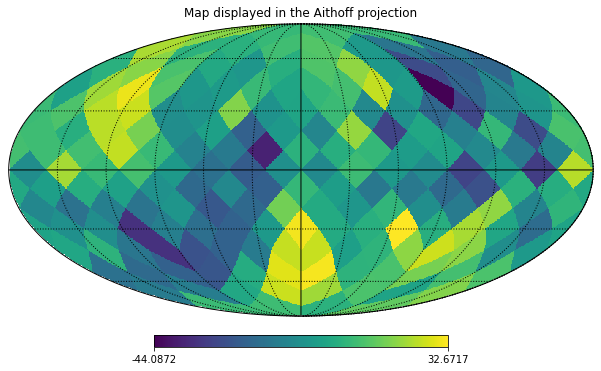

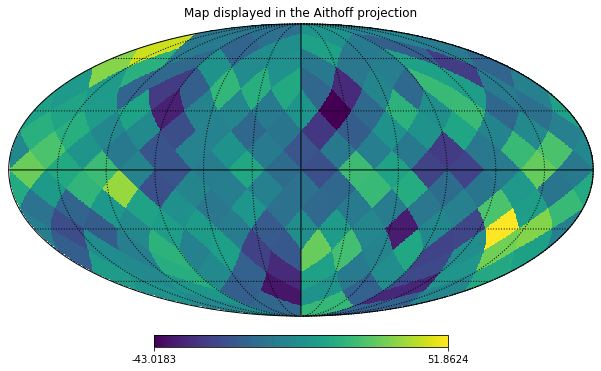

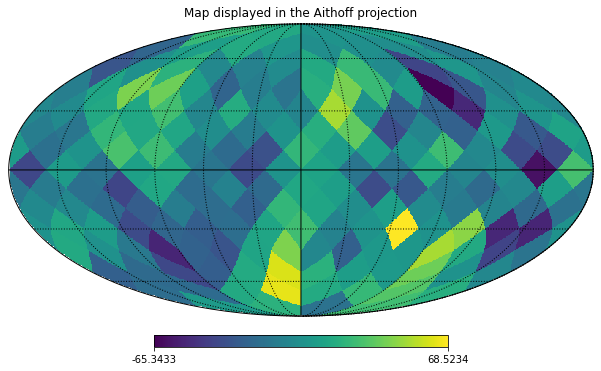

In [98]:
ralm_samples = tf.slice(samples,[0,lmax],[len(samples),len_ralm]) #The real alm samples from the adaptive step size HMC
ialm_samples = tf.slice(samples,[0,(lmax + len_ralm)],[len(samples),len_ralm]) #The imaginary alm samples from the adaptive step size HMC
mean_ralm = [tf.math.reduce_mean(ralm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the real alms
mean_ialm = [tf.math.reduce_mean(ialm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the imaginary alms
std_ralm = [tf.math.reduce_std(ralm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the real alms
std_ialm = [tf.math.reduce_std(ialm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the imaginary alms
mean_alm = splittosingularalm_tf(mean_ralm, mean_ialm) 
hmean_alm = almmotho(mean_alm,lmax)
mean_map = almtomap(hmean_alm,NSIDE) #The mean samples from the HMC as a map

mollviewmap(orig_map) #Plot of the original map
mollviewmap(mean_map) #Plot of the mean samples from the HMC as a map
mollviewmap(abs(orig_map - mean_map)) #A plot of the difference between the original and sampled maps.
print('Original Map =',orig_map)
print('Estimated Map =',mean_map)

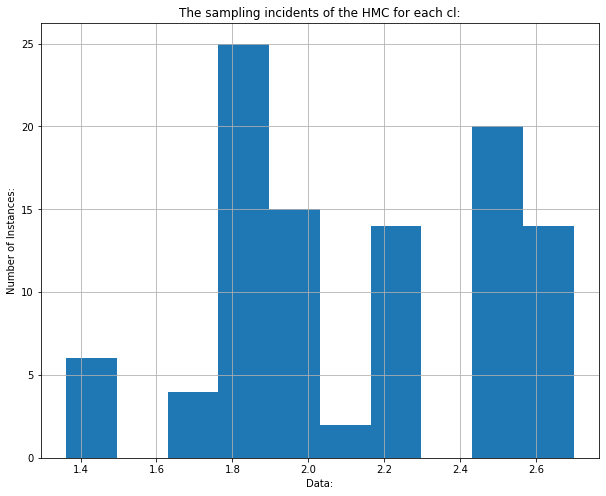

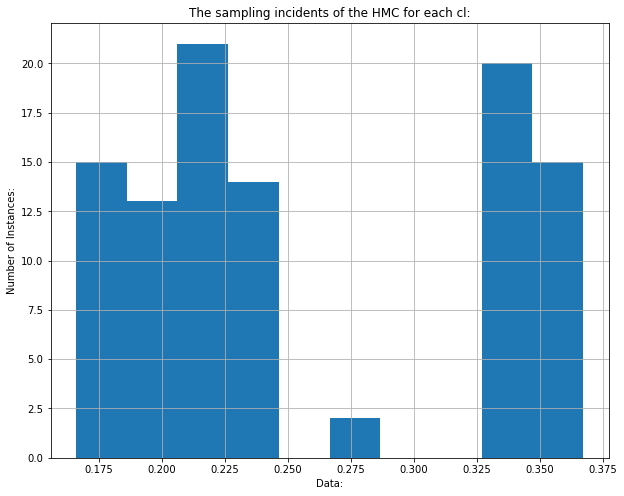

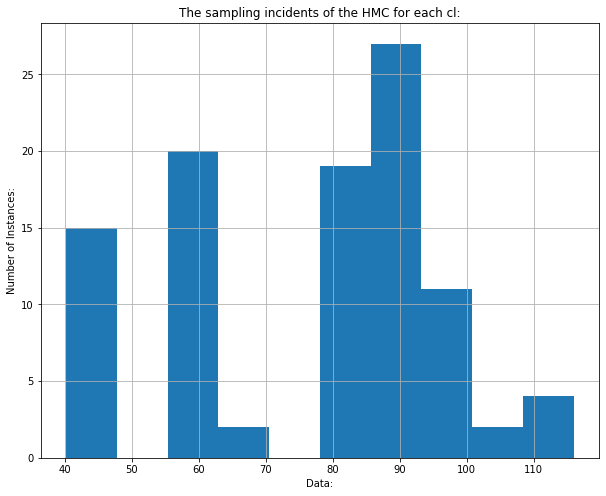

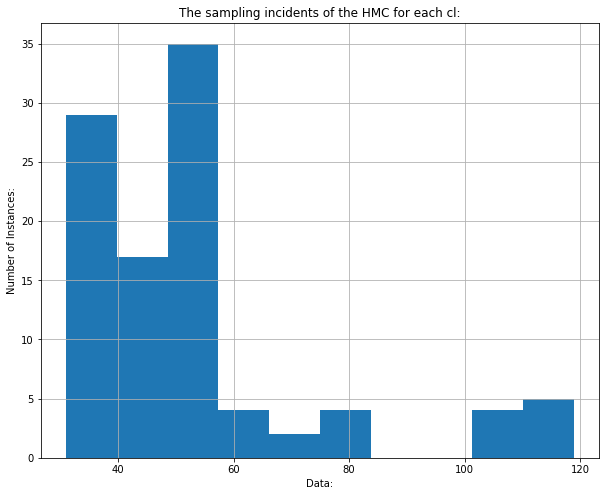

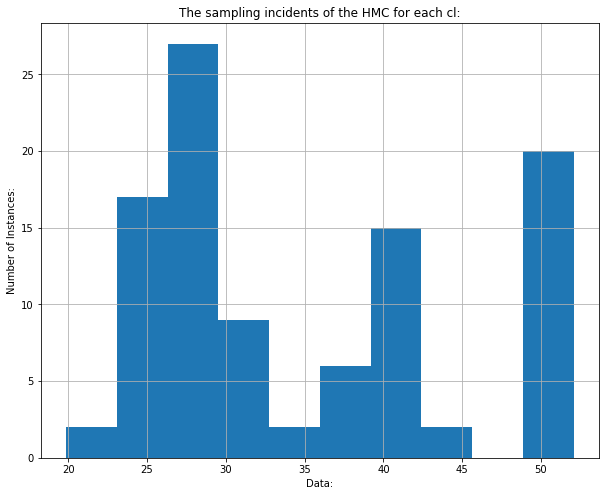

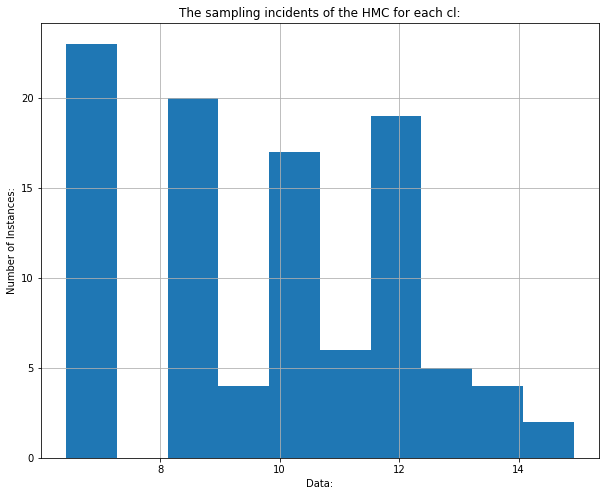

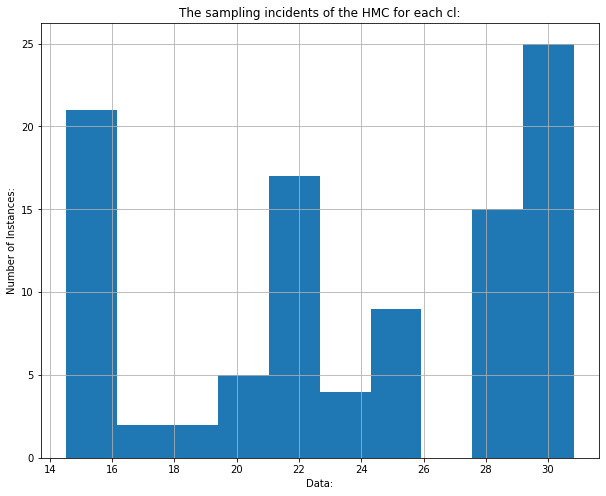

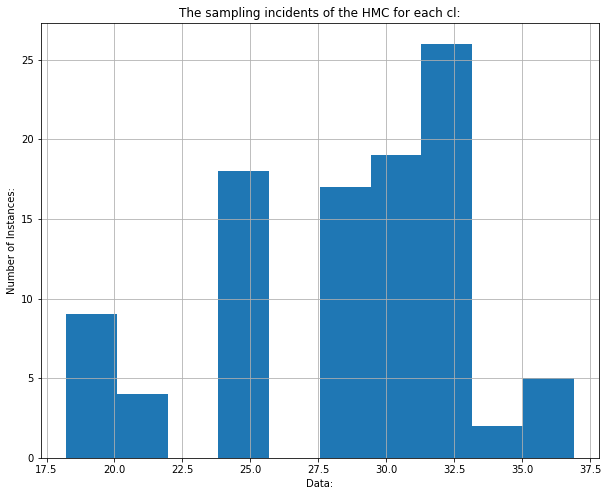

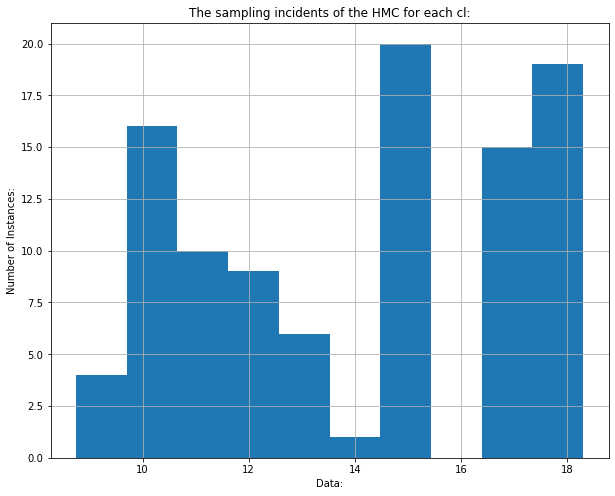

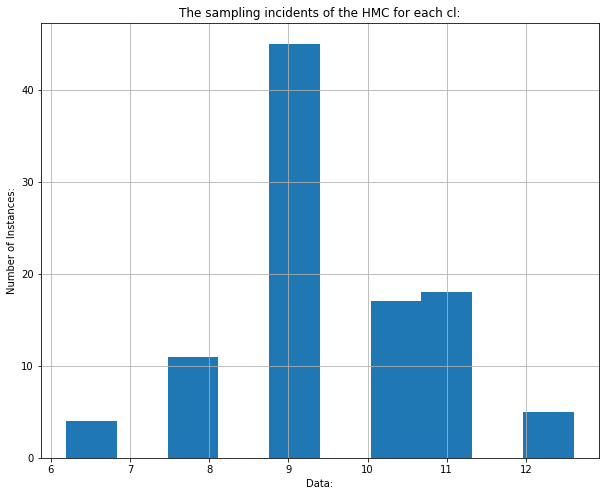

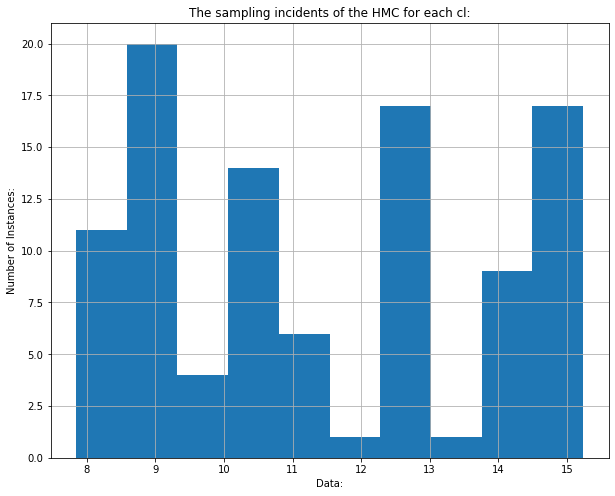

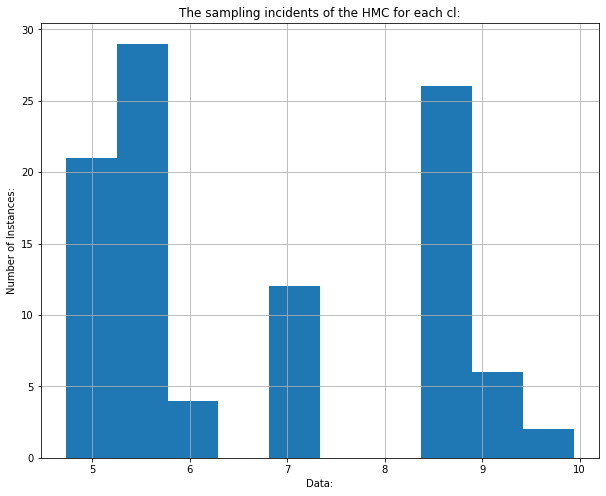

In [99]:
for i in range(lmax):
    plt.figure(figsize = [10,8])
    plt.hist((cl_samples[:,i].numpy()))  #Histogram of the sampled cls for each l value.
    plt.grid()
    plt.xlabel('Data:')
    plt.ylabel('Number of Instances:')
    plt.title('The sampling incidents of the HMC for each cl:')
    plt.show()

In [36]:
#[insert here where your maps are coming from]


# loop over samples (what we want!)
#saves the frames:
Maps = [noisemap1,noisemap2]
i = 0
for s in Maps:
    # s[0] is the first bin!
    hp.mollview(s[1][0], min=-0.0115, max=0.0115, title="Bin 2 - $\kappa_1$ ")
    N = str(i).zfill(3)
    plty.savefig(f'/path/to/saving/frames/Kappa_2-frame-{N}.png', bbox_to_inches='tight')
    plty.close()
    i += 1

# Creates the gif:
# filepaths
fp_in = "/path/to/saving/frames/Kappa_2-frame-*.png"
fp_out = "/path/to/saving/gifs/kappa_2.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=80, loop=0, optimize=False)


IndexError: invalid index to scalar variable.